# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [288]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [289]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

In [290]:
import pysal

In [291]:
import geopandas as gp

## Working with Shape File

### Loading Census Tract Shape File¶

In [292]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [293]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

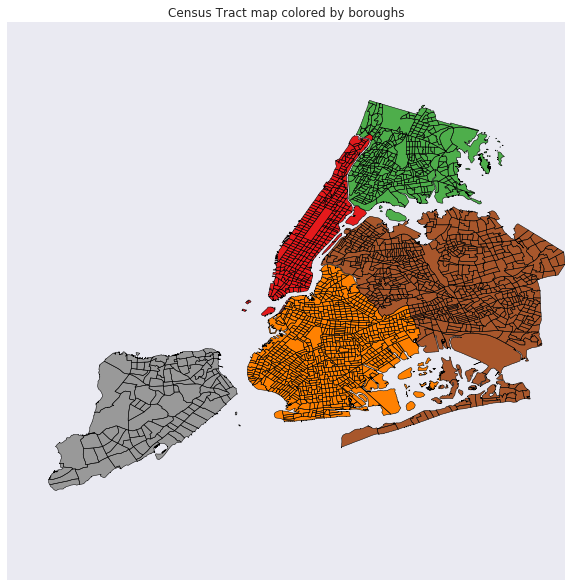

In [294]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [295]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [296]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

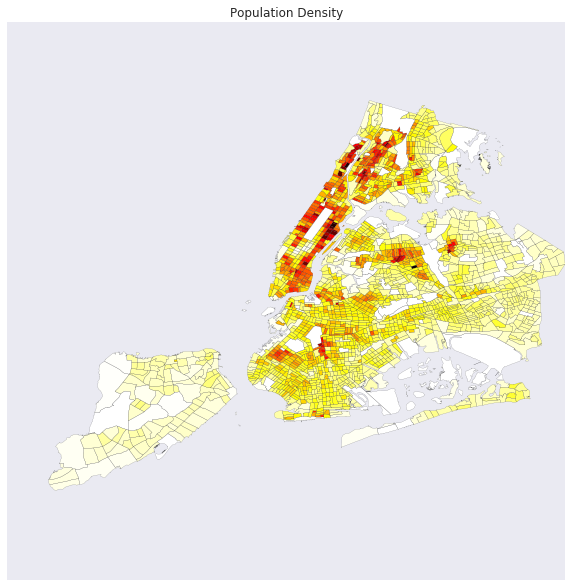

In [297]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data


### Load CitiBike data

In [298]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [299]:
df_bike_monthly.shape

(36, 543)

In [300]:
df_bike_monthly['month'] = df_bike_monthly.index.month
df_bike_monthly['month']

starttime
2013-07-31     7
2013-08-31     8
2013-09-30     9
2013-10-31    10
2013-11-30    11
2013-12-31    12
2014-01-31     1
2014-02-28     2
2014-03-31     3
2014-04-30     4
2014-05-31     5
2014-06-30     6
2014-07-31     7
2014-08-31     8
2014-09-30     9
2014-10-31    10
2014-11-30    11
2014-12-31    12
2015-01-31     1
2015-02-28     2
2015-03-31     3
2015-04-30     4
2015-05-31     5
2015-06-30     6
2015-07-31     7
2015-08-31     8
2015-09-30     9
2015-10-31    10
2015-11-30    11
2015-12-31    12
2016-01-31     1
2016-02-29     2
2016-03-31     3
2016-04-30     4
2016-05-31     5
2016-06-30     6
Name: month, dtype: int32

In [301]:
df_bike_monthly.loc[(df_bike_monthly['month'] >= 3) & (df_bike_monthly['month'] <= 8) ,'season']= 'summer'
#df_bike_monthly.loc[(df_bike_monthly['month'] < 3) & (df_bike_monthly['month'] > 8) ,'season']= 'winter'
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1535,1536,1537,1538,1539,1540,1541,1542,month,season
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,7,summer
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,8,summer
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,9,NaN
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,10,NaN
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,11,NaN


In [302]:
df_bike_monthly.fillna('winter')

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1535,1536,1537,1538,1539,1540,1541,1542,month,season
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,7,summer
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,8,summer
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,9,winter
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,10,winter
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,11,winter
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,12,winter
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,1,winter
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,2,winter
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,3,summer


In [303]:
#df1 = df[df['Sales'] >= s]
df_season_summer = df_bike_monthly[df_bike_monthly['season'] == 'summer']
df_season_summer

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1535,1536,1537,1538,1539,1540,1541,1542,month,season
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,7,summer
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,8,summer
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,3,summer
2014-04-30,1319,2315,7056,2371,4479,2266,1417,3288,3000,1540,...,0,0,0,0,0,0,0,0,4,summer
2014-05-31,1696,3125,9070,3115,6207,2897,2049,3579,3863,2062,...,0,0,0,0,0,0,0,0,5,summer
2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,3694,2422,...,0,0,0,0,0,0,0,0,6,summer
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,7,summer
2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,0,8,summer
2015-03-31,1012,0,3574,1401,2201,2047,617,1867,1505,769,...,0,0,0,0,0,0,0,0,3,summer


In [304]:
del df_season_summer['season']
del df_season_summer['month']
df_season_summer.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0
2014-04-30,1319,2315,7056,2371,4479,2266,1417,3288,3000,1540,...,0,0,0,0,0,0,0,0,0,0
2014-05-31,1696,3125,9070,3115,6207,2897,2049,3579,3863,2062,...,0,0,0,0,0,0,0,0,0,0


In [305]:
df_season_winter = df_bike_monthly[df_bike_monthly['season'] != 'summer']
df_season_winter

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1535,1536,1537,1538,1539,1540,1541,1542,month,season
starttime,,,,,,,,,,,,,,,,,,,,,
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,9,NaN
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,10,NaN
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,11,NaN
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,12,NaN
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,1,NaN
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,2,NaN
2014-09-30,2281,3678,10357,3680,7740,3695,2217,4112,3504,2315,...,0,0,0,0,0,0,0,0,9,NaN
2014-10-31,2213,3121,8881,3268,6624,4106,1798,3989,3270,2193,...,0,0,0,0,0,0,0,0,10,NaN
2014-11-30,1437,1863,5980,2339,4069,2836,1148,2584,2109,1399,...,0,0,0,0,0,0,0,0,11,NaN


In [306]:
del df_season_winter['season']

In [307]:
del df_season_winter['month']


In [308]:
df_season_winter.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

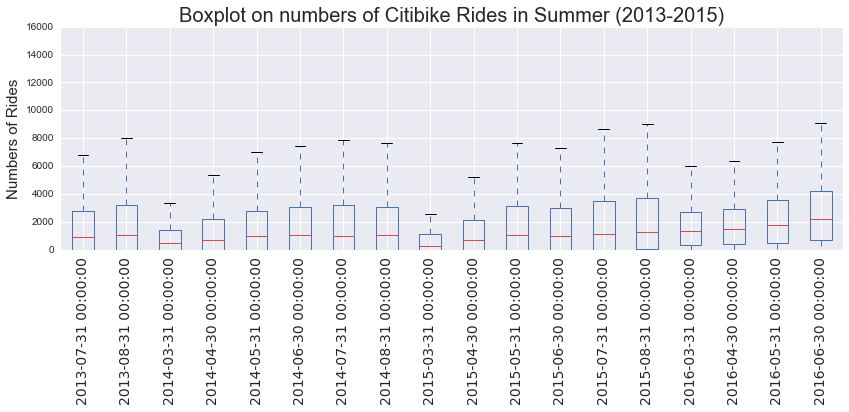

In [368]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))


df_season_summer_=df_season_summer.copy()
#df_season_winter.index=df_season_winter.index.strftime("%B %Y")
df_season_summer.T.boxplot(figsize=(15,7),ax=ax,rot=90);
#ax.set_ylim([-200,16000])
ax.set_ylabel("Numbers of Rides", fontsize = 15)

ax.set_title("Boxplot on numbers of Citibike Rides in Summer (2013-2015)", fontsize = 20)

The above boxplot graph, the X axis represents the months and the Y axis represents the numbers of rides.

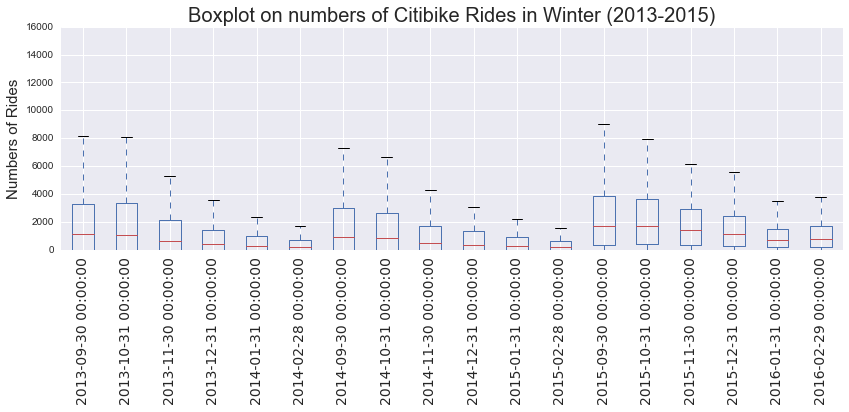

In [370]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))


df_season_winter_=df_season_winter.copy()
#df_season_winter.index=df_season_winter.index.strftime("%B %Y")
df_season_winter.T.boxplot(figsize=(15,7),ax=ax,rot=90);
#ax.set_ylim([-200,16000])
ax.set_ylabel("Numbers of Rides", fontsize = 15)
ax.set_title("Boxplot on numbers of Citibike Rides in Winter (2013-2015)", fontsize = 20)

The above boxplot graph, the X axis represents the months and the Y axis represents the numbers of rides.

Winter

In [371]:
df_bike_monthly = df_season_winter

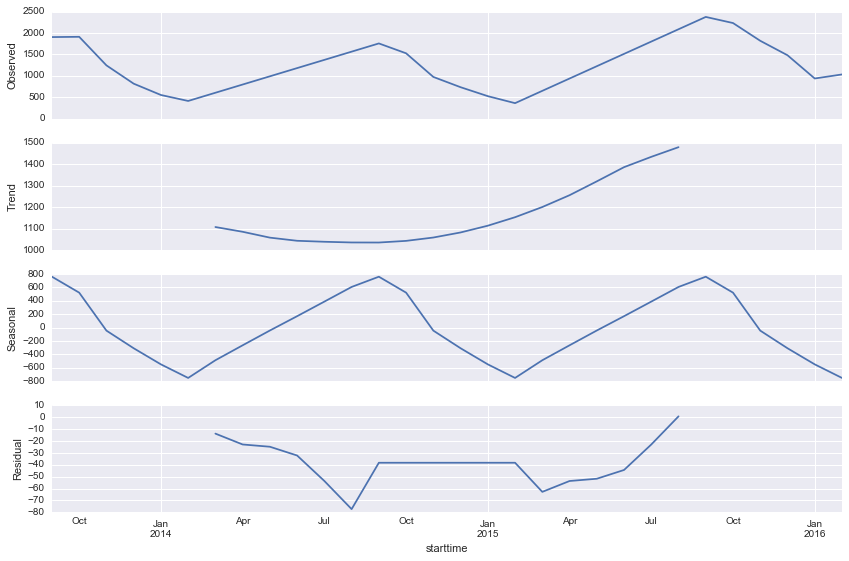

In [372]:
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace = True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize'] = (12,8)
resplot = res.plot()

In [373]:
df_bike_monthly = df_season_summer

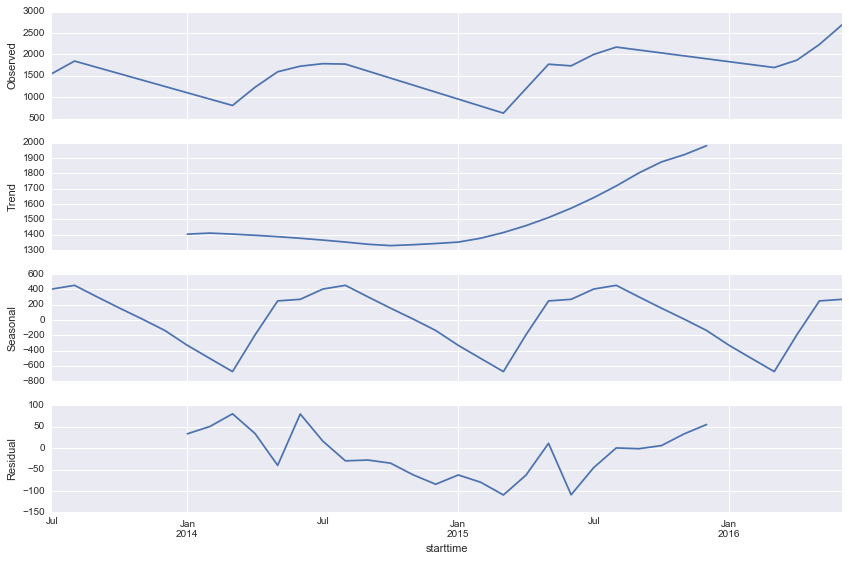

In [374]:
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace = True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize'] = (12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [311]:
station_id=DataFrame.from_csv('Data/Station_id.csv')

#convert station_ids to string index
station_id.index=station_id.index.astype(str)

station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [312]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [313]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [314]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [315]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['winterAve']=df_season_winter.sum()
station_id['summerAve']=df_season_summer.sum()

In [316]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,winterAve,summerAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,31497,37811
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,43535,59289
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,119505,154020
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,44270,57679
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,81149,102895


### Add the monthly average rides to the CT shapefile 

In [317]:
# use the 
temp=station_id[['winterAve']]
temp['summerAve'] = station_id[['summerAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']

C:\Users\Pooneh\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Pooneh\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [318]:
temp

,winterAve,summerAve,station_id
BoroCT2010,,,
1009000,31497,37811,1000
1009900,43535,59289,1001
1005700,119505,154020,1002
1001800,44270,57679,1003
1006100,81149,102895,1004
1004400,52418,66034,1005
1001501,24729,34093,1006
1003200,53750,75594,1007
1012500,44685,48684,1008


In [319]:
ct_shape_SeasonalAve=ct_shape.join(temp)
ct_shape_SeasonalAve.fillna(0,inplace=True)

In [320]:
ct_shape_SeasonalAve

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,winterAve,summerAve,station_id
BoroCT2010,,,,,,,,,,,,,,,
1000100,1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0.0,0.0,0
1000201,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0.0,0.0,0
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,13971.0,24875.0,1197
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,16663.0,21170.0,1229
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,28931.0,30201.0,1329
1000500,1000500,1,Manhattan,I,000500,5,MN99,park-cemetery-etc-Manhattan,3810,9.081808e+06,32407.899284,(POLYGON ((-74.01092841268032 40.6844914725429...,1166.0,1214.0,1365
1000500,1000500,1,Manhattan,I,000500,5,MN99,park-cemetery-etc-Manhattan,3810,9.081808e+06,32407.899284,(POLYGON ((-74.01092841268032 40.6844914725429...,1118.0,2618.0,1367
1000500,1000500,1,Manhattan,I,000500,5,MN99,park-cemetery-etc-Manhattan,3810,9.081808e+06,32407.899284,(POLYGON ((-74.01092841268032 40.6844914725429...,0.0,1503.0,1537
1000600,1000600,1,Manhattan,E,000600,6,MN28,Lower East Side,3809,2.583418e+06,6970.634587,POLYGON ((-73.99022012603876 40.71440493989794...,42221.0,57383.0,1140


### Removing the CTs that are out of zoom boundries

In [321]:
ct_shape__SeasonalAve_Zoom=(ct_shape_SeasonalAve[ct_shape_SeasonalAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

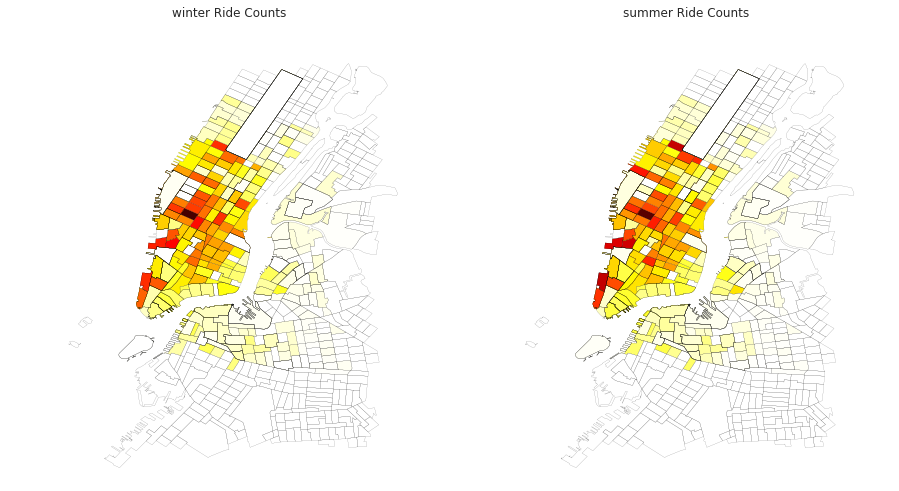

In [367]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ct_shape__SeasonalAve_Zoom.plot(column='winterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_axis_off()
ax1.set_title("winter Ride Counts")




ax2 = fig.add_subplot(122)

ct_shape__SeasonalAve_Zoom.plot(column='summerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)

ax2.set_axis_off()
ax2.set_title("summer Ride Counts")





Above are the zoomed heatmaps, we can see the citibike are expanding during the summer, relatively.

In [323]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs(winter):", len(temp.winterAve)
print "Number of zoomed CTs(sumer):", len(temp.summerAve)

Total number of CTs: 2166
Number of zoomed CTs(winter): 543
Number of zoomed CTs(sumer): 543


### Export Shapefile CTs in the CitiBike Zone

In [324]:
path='Data/ct_shape__SeasonalAve_Zoom.shp'
ct_shape__SeasonalAve_Zoom.to_file(path)
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


## Exploratory Geospatial Analysis

In [325]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [326]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [327]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [328]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [329]:
Wmatrix, ids = qW_CT.full()

In [330]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [331]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [332]:
WinterRide = ct_shape__SeasonalAve_Zoom.winterAve
WinterRideLag = ps.lag_spatial(qW_CT, WinterRide)
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=   119.857                 2
  119.857 < x[i] <=  1876.750                78
 1876.750 < x[i] <=  4509.059                80
 4509.059 < x[i] <=  7565.413                79
 7565.413 < x[i] <= 11064.048                80
11064.048 < x[i] <= 24831.318                79
24831.318 < x[i] <= 34872.071                80
34872.071 < x[i] <= 41156.721                79
41156.721 < x[i] <= 65502.071                80

In [333]:
SummerRide = ct_shape__SeasonalAve_Zoom.summerAve
SummerRideLag = ps.lag_spatial(qW_CT, SummerRide)
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   117.714                21
  117.714 < x[i] <=  2265.850                78
 2265.850 < x[i] <=  5139.800                80
 5139.800 < x[i] <= 10093.650                79
10093.650 < x[i] <= 15484.867                80
15484.867 < x[i] <= 33398.440                79
33398.440 < x[i] <= 48054.864                80
48054.864 < x[i] <= 55933.250                79
55933.250 < x[i] <= 86481.286                80

#### Map the monthly rides lag

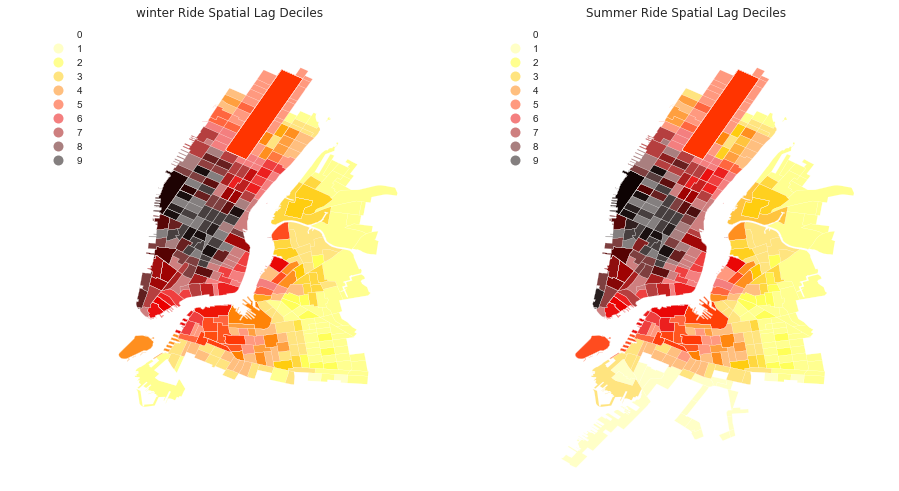

In [365]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ct_shape__SeasonalAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax1.set_title("winter Ride Spatial Lag Deciles")




ax2 = fig.add_subplot(122)

ct_shape__SeasonalAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)

ax2.set_axis_off()
ax2.set_title("Summer Ride Spatial Lag Deciles")


Above are graphs that show the summer and winter rides lag. We can see in the summer, there are more rides around the city. 

## Global  Spatial Autocorrelation

In [336]:
a1 = np.polyfit(WinterRide, WinterRideLag, 1)[1]
b1 = np.polyfit(WinterRide, WinterRideLag, 1)[0]
a2 = np.polyfit(SummerRide, SummerRideLag, 1)[1]
b2 = np.polyfit(SummerRide, SummerRideLag, 1)[0]

a1,b1,a2,b2

(5368.4517010711425,
 0.65415251016634168,
 7381.8510048866565,
 0.64742537955062962)

### Moran Scatterplot

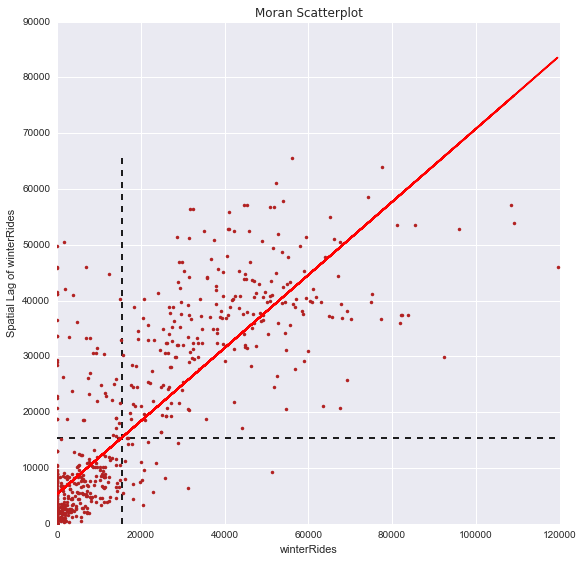

In [337]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(WinterRide,WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a1 + b1*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of winterRides')
plt.xlabel('winterRides')

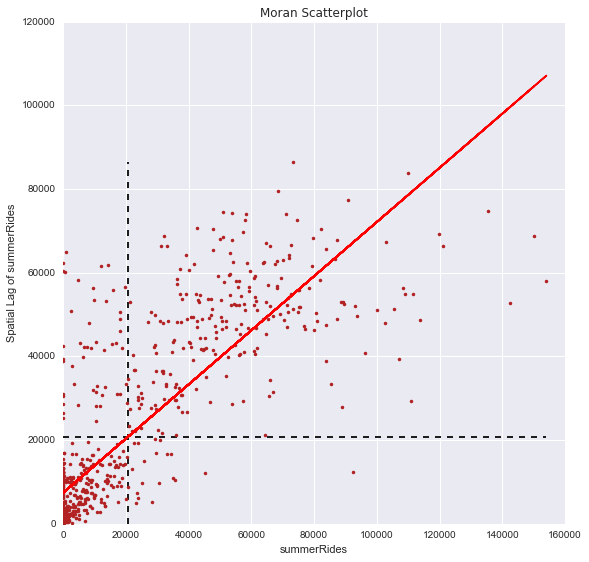

In [363]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(SummerRide,SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a2 + b2*SummerRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of summerRides')
plt.xlabel('summerRides')

### Moran's I

In [339]:
I_WinterRide = ps.Moran(WinterRide, qW_CT)
I_SummerRide = ps.Moran(SummerRide, qW_CT)

In [340]:
I_WinterRide.I, I_WinterRide.p_sim

(0.65431284847496418, 0.001)

In [341]:
I_SummerRide.I, I_SummerRide.p_sim

(0.64757795598496704, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [342]:
I_WinterRide.sim[0:10]

array([ 0.00047379,  0.0247654 ,  0.01148931,  0.03280599, -0.01241928,
        0.001786  ,  0.02489977, -0.0188865 ,  0.00542844, -0.01456314])

In [343]:
I_SummerRide.sim[0:10]

array([ 0.00532594,  0.01051417, -0.02404481, -0.00496878, -0.00267502,
       -0.01614033,  0.01377656,  0.01013455, -0.02183259, -0.01638212])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [344]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

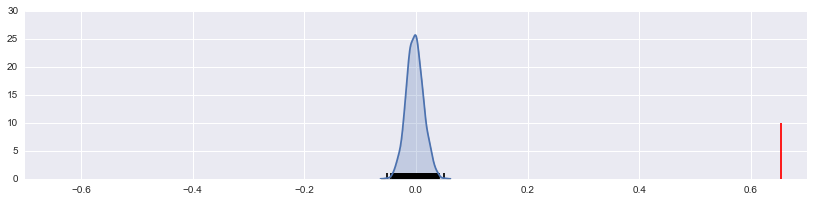

In [345]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

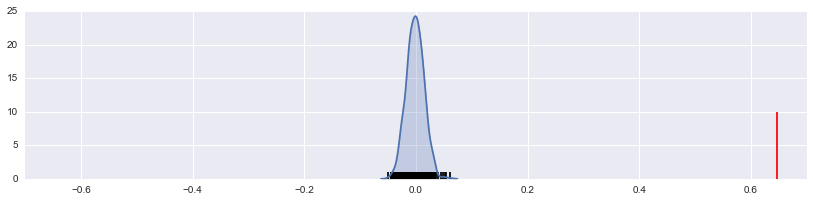

In [346]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

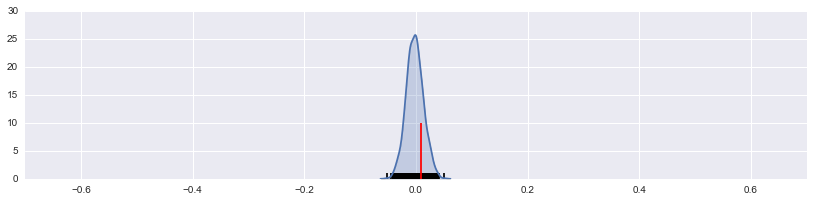

In [347]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

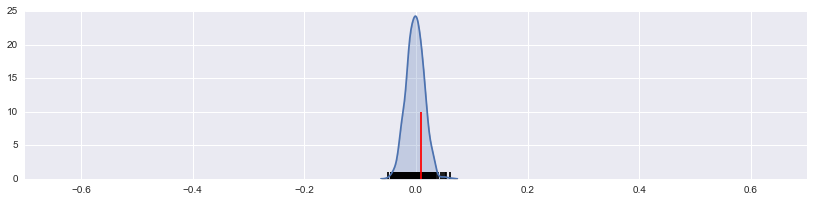

In [348]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [349]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)

In [350]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)

In [351]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([ -0.00000000e+00,  -2.54289768e-01,  -8.49562917e-04,
          1.12122005e-04,  -2.93415998e-02]),
 array([ 0.001,  0.179,  0.487,  0.458,  0.452]))

In [352]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.24944556,  0.01176949,  0.00157105,  0.02150326]),
 array([ 0.001,  0.172,  0.377,  0.367,  0.37 ]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [353]:
sigs = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

In [354]:
sigs_summer = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs_summer = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs_summer = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs_summer = SummerRideLag[LMo_SummerRide.p_sim > .001]

### Plot Signficant LISA

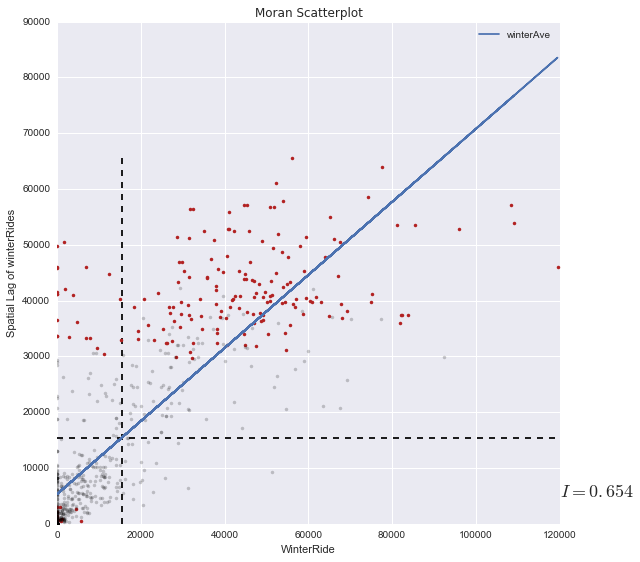

In [387]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a1 + b1*WinterRide)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of winterRides')
plt.xlabel('WinterRide')
plt.legend()




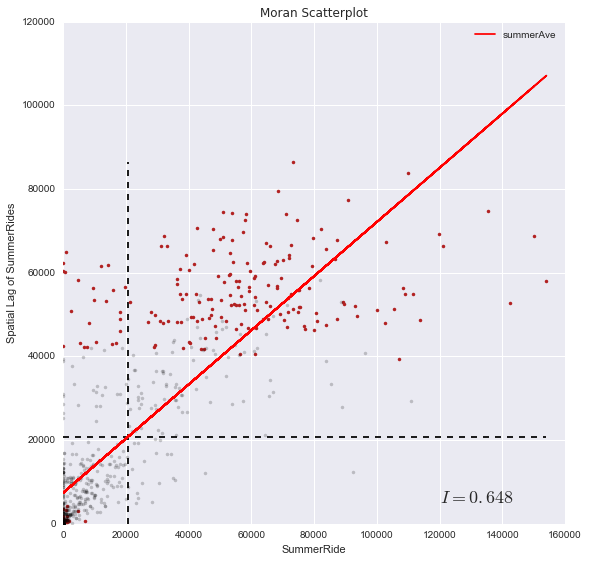

In [386]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_summer, W_sigs_summer, '.', color='firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a2 + b2*SummerRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of SummerRides')
plt.xlabel('SummerRide')
plt.legend()

### Hot and Cold spots 

In [247]:
sig = LMo_WinterRide.p_sim < 0.01
hotspots = LMo_WinterRide.q==1 * sig
coldspots = LMo_WinterRide.q==3 * sig
print "Number of Hotspots for winter:", hotspots.sum()
print "Number of Coldspots for winter:", coldspots.sum()

Number of Hotspots for winter: 193
Number of Coldspots for winter: 215


In [357]:
sig_summer = LMo_SummerRide.p_sim < 0.01
hotspots_summer = LMo_SummerRide.q==1 * sig_summer
coldspots_summer = LMo_SummerRide.q==3 * sig_summer
print "Number of Hotspots for Summer:", hotspots_summer.sum()
print "Number of Coldspots for Summer:", coldspots_summer.sum()

Number of Hotspots for Summer: 186
Number of Coldspots for Summer: 231


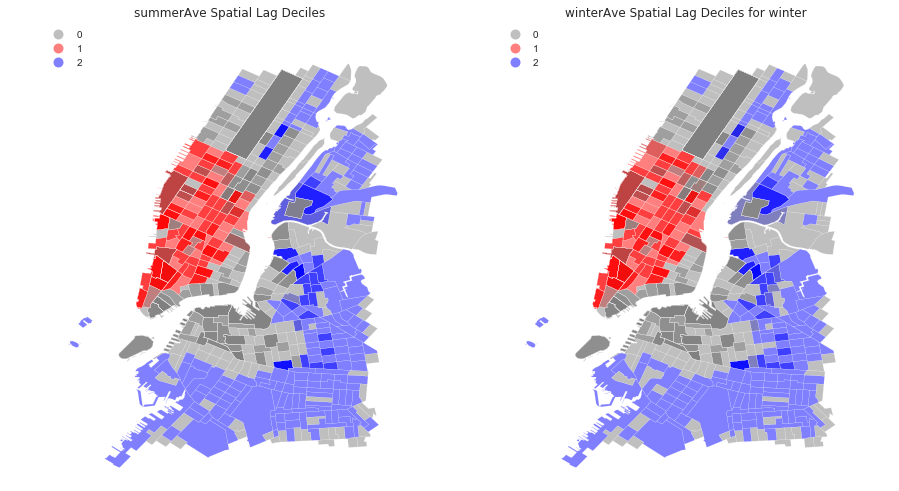

In [362]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_summer = hotspots_summer*1 + coldspots_summer*2
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ct_shape__SeasonalAve_Zoom.assign(cl = hotcold_summer).plot(column = 'cl', categorical = True, 
        k=10, cmap = hcmap, linewidth = 0.1, ax = ax1, 
        edgecolor = 'white', legend = True)
ax1.set_axis_off()
ax1.set_title("summerAve Spatial Lag Deciles")



hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2


ax2 = fig.add_subplot(122)
ct_shape__SeasonalAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_axis_off()
ax2.set_title("winterAve Spatial Lag Deciles for winter")

Since the heatmap are created with weighted average, so comparing to two season could not be so accurate because each season is ploting against it self on an average base.